## CASH-4373: Shipper Guide Lane Selection  (USA, FTL, DRV only)

### Goal: Identify most relevant ZIP3 lanes in terms of quoting volume and weekly frequency in SHIPPER GUIDE


Given data points request constraints, the necessity to follow up market conditions and dynamically assess shipper's activity in terms of quotes in SG, we need to come up with minimum requirements to select Top SG lanes (ZIP3 level)

### Lane Selection  Methodology

The SG Top Lanes selection is based on a weighted score per ZIP3 lane which accounts for quoting volume (past 60 days) and weekly frequency (past 4 weeks);

#### Volume score (30%)
* Have at least one quote request per week over the last 4 weeks. This generates a minimum threshold of 4 quotes per lane;
* Splitting the lanes into buckets based on a kmeans methodology;
* Apply score volume rule → Extract score_volume per lane

#### Frequency score (70%)
* Identify the relative frequency with which there was at least one quote request in the last 4 weeks; 
* Apply score frequency rule → Extract score_frequency per lane

#### Final score_lane 
* score_lane = Score_volume + score_frequency 
* Set a minimum threshold of score_lane = 0.5 to be eligible as a SG Top Lane.

In [1]:
# Load required packages

from pricing_analysis_utils import read_cached_sql
import numpy as np
import pandas as pd

import seaborn as sns

sns.set()

# Plot histagrans
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Supressing warnings
import warnings

# Group split
from sklearn.preprocessing import KBinsDiscretizer

warnings.filterwarnings("ignore")

In [2]:
# Format settings:
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [3]:
df = read_cached_sql(open("queries/quotes_sg.sql", "r").read(), use_trino=True)

INFO:root:Reading from cache (sql_cache\6001f32a_trino.parquet)...
INFO:root:Fetched 11755 rows.


In [4]:
### Keep only USA lanes
df = df[~df["od_pair"].str.contains("[a-zA-Z]").fillna(False)]

### Shipper Guide datapoints

Initially, we must group the data by ZIP3 lane (od_pair) to assess its quoting dynamic characteristics.

In [5]:
## Evaluate shipper relevance per quotes share

stats_od = (
    df.groupby(["od_pair"], as_index=True, sort=True)
    .agg(
        {
            "quote_id": ["size"],
            "mileage": ["mean"],
            "booking_counter": ["sum"],
            "company_name": ["nunique"],
            "quotes_7": ["sum"],
            "quotes_8_14": ["sum"],
            "quotes_15_21": ["sum"],
            "quotes_22_28": ["sum"],
        }
    )
    .round(2)
)

stats_od.columns = stats_od.columns.droplevel(1)
stats_od = stats_od.rename(
    {"quote_id": "#_quotes", "mileage": "avg_miles", "booking_counter": "#_bookings"},
    axis=1,
)

stats_od["quotes_share"] = stats_od["#_quotes"] / len(df) * 100
stats_od = stats_od.sort_values(by="#_quotes", ascending=False)
stats_od = stats_od[
    [
        "#_quotes",
        "quotes_share",
        "#_bookings",
        "avg_miles",
        "company_name",
        "quotes_7",
        "quotes_8_14",
        "quotes_15_21",
        "quotes_22_28",
    ]
]

In [6]:
print("\n# Unique Shippers on the last 60 days", df["company_name"].nunique())

print("\n# Unique zip3 lanes on the last 60 days", df["od_pair"].nunique())

print("\n# ZIP3 lanes with more than 1 quotes", len(stats_od[stats_od["#_quotes"] > 1]))

print("\n# ZIP3 lanes with at least 6 quotes", len(stats_od[stats_od["#_quotes"] >= 6]))

print(
    "\n# ZIP3 lanes with at least than 10 quotes",
    len(stats_od[stats_od["#_quotes"] >= 10]),
)


# Unique Shippers on the last 60 days 404

# Unique zip3 lanes on the last 60 days 5172

# ZIP3 lanes with more than 1 quotes 2073

# ZIP3 lanes with at least 6 quotes 306

# ZIP3 lanes with at least than 10 quotes 102


### Assess quoting volume summary statistics

In [7]:
stats_od["#_quotes"].describe()

count   5172.00
mean       2.19
std        3.96
min        1.00
25%        1.00
50%        1.00
75%        2.00
max      171.00
Name: #_quotes, dtype: float64

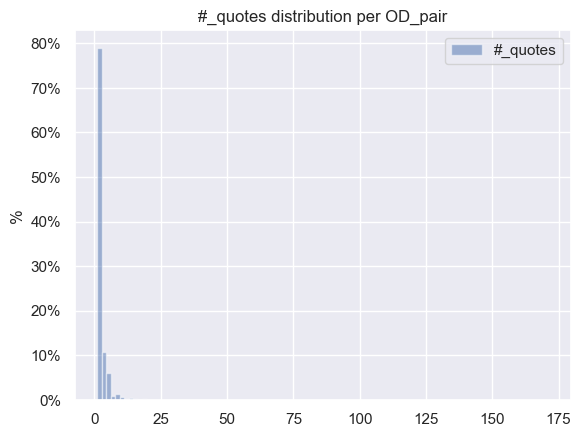

In [8]:
### #_quotes distribution

plt.hist(
    stats_od["#_quotes"],
    bins=100,
    alpha=0.5,
    label="#_quotes",
    weights=np.ones(len(stats_od)) / len(stats_od),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("#_quotes distribution per OD_pair")
plt.show()

Since we have such skewed data towards toward lanes with extremely low quoting volume, we need to come up with some strategies that can smooth out this situation

### First filter (#_quotes):

The idea of ​​this first filter is to reduce the number of lanes that can be selected based on the total volume of quote requests. Thus, Based on the descriptive statistics of the #_quote series, the following criterion was adopted: $mean + 1\sigma$, which gives us a minimum threshold of 6 quotes per od_pair.

In [9]:
stats_od = stats_od[stats_od["#_quotes"] >= 6]

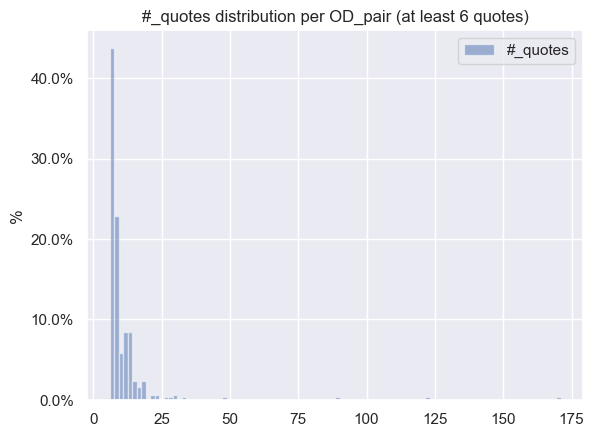

In [10]:
### #_quotes distribution per OD_pair

plt.hist(
    stats_od["#_quotes"],
    bins=100,
    alpha=0.5,
    label="#_quotes",
    weights=np.ones(len(stats_od)) / len(stats_od),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("#_quotes distribution per OD_pair (at least 6 quotes)")
plt.show()

## Set score_volume $\rightarrow$ 30%

### Split ZIP3 lanes by quoting volume 

Notice that:
* Using lane quote share won't make much difference since a monotonic transformation would even lower the values. Thus, discretizing the #_quotes into buckets should be done to better differentiate the lanes. 
* Three approaches have been tested:
  1. Split by quantile/decile
  2. Split by kmeans
  3. Hard code

### 1. Split by quantile/decile

In [11]:
stats_od["#_quotes"].describe()

count   306.00
mean     10.70
std      13.05
min       6.00
25%       6.00
50%       8.00
75%      11.00
max     171.00
Name: #_quotes, dtype: float64

In [12]:
# Discretizing into buckets with a list of deciles

# stats_od["DecileRank"] = pd.qcut(
#     stats_od["#_quotes"], q=10, labels=False, duplicates="drop"
# )

## If I want to make perfect decils

stats_od["NumberRanks"] = stats_od["#_quotes"].rank(method="first")
stats_od["DecileRank"] = stats_od["#_quotes"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)

stats_test = (
    stats_od.groupby(["DecileRank"], as_index=True, sort=True)
    .agg({"DecileRank": ["size"], "#_quotes": ["min", "max"]})
    .round(2)
)
stats_test

DecileRank #_quotes     
                 size      min  max
DecileRank                         
1                  31        6    6
2                  31        6    6
3                  30        6    7
4                  31        7    7
5                  30        7    8
6                  31        8    9
7                  30        9   10
8                  31       10   12
9                  30       12   15
10                 31       15  171

#### Split by quantile/decile results:

The descriptive statistics of the series indicate that the division based on quantiles/deciles does not present good results.

The 75th quantile has a large spread in total citations, ranging from 11 to 170, which is unrealistic

* Main reason for that: 
    * Fractiles splits assume uniform/normal distribution underlying the data series;
    * The quantile function divides the data into equal halves which, due to the statistical characteristics of the series, do not make much sense.

### 2. Split by kmeans

Since approaches that assume uniform/normal distribution data series won't work, need to think of something that accounts for non-uniform data points. Thus, decided to apply kmeans  

* K-means intends to divide ’n’ number of points into ‘K’ clusters where each point in cluster ‘Xi’ is similar or we can say have small ‘intra-cluster distance’ and have high ‘inter-cluster distance’. This is the basic intuition of K-means clustering $\rightarrow$ There is no longer a need for equals halves.


In [13]:
est = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="kmeans")
stats_od["kmeans_group"] = est.fit_transform(stats_od[["#_quotes"]])

In [14]:
stats_kmeans = (
    stats_od.groupby(["kmeans_group"], as_index=True, sort=True)
    .agg({"kmeans_group": ["size"], "#_quotes": ["min", "max"]})
    .round(2)
)

stats_kmeans

kmeans_group #_quotes     
                     size      min  max
kmeans_group                           
0.00                  162        6    8
1.00                   86        9   12
2.00                   35       13   16
3.00                   12       17   22
4.00                    6       24   30
5.00                    1       34   34
6.00                    1       48   48
7.00                    1       89   89
8.00                    1      122  122
9.00                    1      171  171

Notice that some groups have only 1 element. This occurs again due to the characteristics of the series.

While there is a concentration of lanes with 6 to 8 quote requests (extremely similar profile), as the number of quotes increases, there is an increase in the dispersion of this characteristic, reducing the number of elements per group.

Despite this situation, I manage to split the ZIP3 lanes quoting profile similarity, without the need to adopt any ad hoc value.

In [53]:
## Set score volume rule - Consider 30% weight


def volume_rank(df):
    if df["kmeans_group"] == 9:
        return 1 * (0.3)
    if df["kmeans_group"] == 8:
        return 1 * (0.3)
    if df["kmeans_group"] == 7:
        return 1 * (0.3)
    if df["kmeans_group"] == 6:
        return 1 * (0.3)
    if df["kmeans_group"] == 5:
        return 0.4 * (0.3)
    if df["kmeans_group"] == 4:
        return 0.3 * (0.3)
    if df["kmeans_group"] == 3:
        return 0.2 * (0.3)
    if df["kmeans_group"] == 2:
        return 0.1 * 0.3
    if df["kmeans_group"] == 1:
        return 0.05 * 0.3
    else:
        return 0.01 * 0.3


## Apply rule
stats_od["score_volume"] = stats_od.apply(volume_rank, axis=1)

In [54]:
stats_od.groupby(["kmeans_group"], as_index=True, sort=True).agg(
    {"kmeans_group": ["size"], "#_quotes": ["min", "max"], "score_volume": ["mean"]}
).round(2)

kmeans_group #_quotes      score_volume
                     size      min  max         mean
kmeans_group                                        
0.00                  162        6    8         0.00
1.00                   86        9   12         0.02
2.00                   35       13   16         0.03
3.00                   12       17   22         0.06
4.00                    6       24   30         0.09
5.00                    1       34   34         0.12
6.00                    1       48   48         0.30
7.00                    1       89   89         0.30
8.00                    1      122  122         0.30
9.00                    1      171  171         0.30

### 3. Hard code

Since there is a unbalanced dataset, we can see that the majority of the groups will have minimum volume weights, thus, we decided to adopt a hard code rule for simplicity

In [68]:
## Set score volume rule - Consider 30% weight


def volume_rank_hc(df):
    if df["#_quotes"] >= 20:
        return 0.3
    if df["#_quotes"] >= 15:
        return 0.2
    else:
        return 0.1


## Apply rule
stats_od["score_volume_hc"] = stats_od.apply(volume_rank_hc, axis=1)

In [69]:
stats_od.reset_index().groupby(["score_volume_hc"], as_index=True, sort=True).agg(
    {"od_pair": ["size"], "#_quotes": ["min", "max"], "score_volume_hd": ["mean"]}
).round(2)

od_pair #_quotes      score_volume_hd
                   size      min  max            mean
score_volume_hc                                      
0.10                274        6   14            0.10
0.20                 19       15   19            0.20
0.30                 13       21  171            0.30

### Set score_frequency $\rightarrow$ 70%

In [65]:
def frequency_1(df):
    if df["quotes_7"] >= 1:
        return 1
    else:
        return 0


def frequency_2(df):
    if df["quotes_8_14"] >= 1:
        return 1
    else:
        return 0


def frequency_3(df):
    if df["quotes_15_21"] >= 1:
        return 1
    else:
        return 0


def frequency_4(df):
    if df["quotes_22_28"] >= 1:
        return 1
    else:
        return 0

In [66]:
## Set score frequency rule - 78% weight

stats_od["freq_1"] = stats_od.apply(frequency_1, axis=1)
stats_od["freq_2"] = stats_od.apply(frequency_2, axis=1)
stats_od["freq_3"] = stats_od.apply(frequency_3, axis=1)
stats_od["freq_4"] = stats_od.apply(frequency_4, axis=1)

stats_od["score_frequency"] = (
    (stats_od["freq_1"] + stats_od["freq_2"] + stats_od["freq_3"] + stats_od["freq_4"])
    / 4
) * 0.7

### Set final score_lane

In [70]:
stats_od["score_lane"] = stats_od["score_volume_hc"] + stats_od["score_frequency"]
stats_od = stats_od.sort_values(by=["score_lane"], ascending=False)
stats_od

,#_quotes,quotes_share,#_bookings,avg_miles,company_name,quotes_7,quotes_8_14,quotes_15_21,quotes_22_28,NumberRanks,...,kmeans_group,score_volume,freq_1,freq_2,freq_3,freq_4,score_frequency,score_lane,score_volume_hd,score_volume_hc
od_pair,,,,,,,,,,,,,,,,,,,,,
330-322,171,1.51,84,355.03,2,53,33,38,47,306.00,...,9.00,0.30,1,1,1,1,0.70,1.00,0.30,0.30
602-547,122,1.07,56,310.00,1,28,48,26,15,305.00,...,8.00,0.30,1,1,1,1,0.70,1.00,0.30,0.30
880-802,48,0.42,21,699.06,1,2,9,8,4,303.00,...,6.00,0.30,1,1,1,1,0.70,1.00,0.30,0.30
300-053,30,0.26,23,1052.37,1,3,3,3,4,301.00,...,4.00,0.09,1,1,1,1,0.70,1.00,0.30,0.30
921-064,17,0.15,8,2877.00,1,4,1,2,3,286.00,...,3.00,0.06,1,1,1,1,0.70,0.90,0.20,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604-344,7,0.06,3,1071.29,2,0,0,0,0,130.00,...,0.00,0.00,0,0,0,0,0.00,0.10,0.10,0.10
296-443,6,0.05,0,592.00,1,0,0,0,0,44.00,...,0.00,0.00,0,0,0,0,0.00,0.10,0.10,0.10
550-799,6,0.05,0,1313.00,1,0,0,0,0,49.00,...,0.00,0.00,0,0,0,0,0.00,0.10,0.10,0.10


### Evaluate score_lane distribution

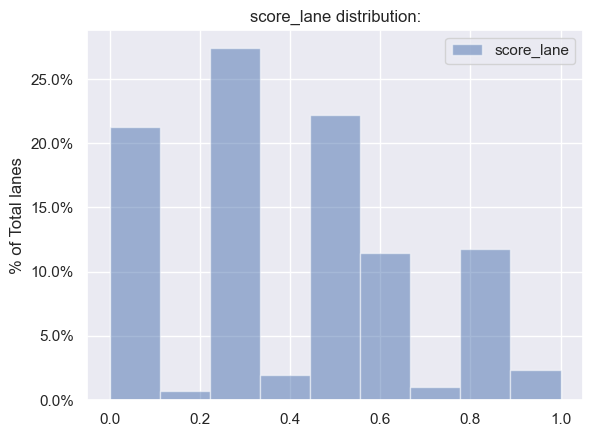

In [71]:
bins = np.linspace(0, 1, 10)

plt.hist(
    stats_od["score_lane"],
    bins,
    alpha=0.5,
    label="score_lane",
    weights=np.ones(len(stats_od)) / len(stats_od),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("% of Total lanes")
plt.title("score_lane distribution:")
plt.show()

In [72]:
stats_od["score_lane"].describe()

count   306.00
mean      0.40
std       0.24
min       0.10
25%       0.28
50%       0.38
75%       0.62
max       1.00
Name: score_lane, dtype: float64

Notice that:
* Roughtly 70% of all selected lanes has a score_lane lower than 0.5;
  * Which indicates that on most lane we have either: low volume and low frequency.
* 81 ZOP3 lanes are within the upper quantile -> Consistent quoting and frequency.

### Set SG Top Lanes selection

Approaches:
1. Rank by quantile
2. Sort by score_lane 

The lanes for extracting historical rates will be those that are part of the upper quartile of the score_lane.

### 1. Rank by quantile

In [81]:
## Lane selection rule: upper quartile
sg_lanes = stats_od.query("score_lane >= score_lane.quantile(.75)")

In [83]:
### Extract selected SG lanes sa series
sg_lanes_list = sg_lanes.reset_index()
sg_lanes_list = sg_lanes_list.iloc[:, 0]

sg_lanes_list

0     330-322
1     602-547
2     880-802
3     300-053
4     921-064
       ...   
76    481-201
77    788-972
78    481-031
79    371-296
80    740-799
Name: od_pair, Length: 81, dtype: object

### Overlap SG TOP lanes with TRAC

TRAC lanes were originally denified on CASH-4305:

You can either extract then from a s3 file or trino table.

In [45]:
## Extract files from aws S3 and save it on a file path

#! aws s3 cp  s3://loadsmart-data-science/pricing-analysis/CASH-4305/df_trac_selected_lanes_rates.csv .

### Table trino: s3_silver.trac.lanes

In [46]:
## Get selected Dry Van lanes previously defined
df_trac = pd.read_csv("df_trac_selected_lanes_rates.csv")
df_trac.set_index("data_timestamp", inplace=True)
df_trac

,805-894,130-301,458-281,648-432,303-282,532-802,805-606,130-071,432-499,850-937,...,972-937,231-086,631-553,543-681,461-010,495-546,480-972,461-563,021-142,780-212
data_timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01,NaN,2.00,2.94,2.30,2.83,2.71,1.25,4.27,2.08,2.06,...,1.80,3.64,2.57,2.93,3.12,2.75,1.76,2.39,2.37,1.95
2019-01-02,NaN,1.99,2.90,2.32,2.82,2.71,1.26,4.23,2.06,1.99,...,1.75,3.69,2.55,2.96,3.11,2.85,1.79,2.40,2.51,1.93
2019-01-03,NaN,2.00,2.88,2.35,2.86,2.74,1.25,4.34,2.08,2.00,...,1.71,3.64,2.55,2.95,3.12,2.86,1.83,2.44,2.58,1.93
2019-01-04,NaN,1.98,2.90,2.35,2.83,2.76,1.25,4.37,2.08,2.05,...,1.71,3.75,2.47,2.87,3.11,2.82,1.82,2.44,2.49,1.94
2019-01-05,NaN,1.97,2.92,2.38,2.85,2.82,1.25,4.40,2.09,2.06,...,1.71,3.75,2.48,2.85,3.12,2.91,NaN,2.44,2.51,1.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20,1.57,1.69,2.27,2.12,2.55,2.62,1.15,3.27,1.96,1.74,...,1.30,3.28,2.39,3.17,2.58,2.69,1.91,2.29,2.10,2.08
2023-05-21,1.59,1.62,2.26,2.10,2.57,2.63,1.16,3.14,1.99,1.74,...,1.29,3.27,2.42,2.35,2.63,2.69,1.94,2.32,2.20,2.08
2023-05-22,1.58,1.70,2.27,2.10,2.57,2.65,1.18,3.25,2.00,1.74,...,1.30,3.33,2.41,3.17,2.61,2.71,1.90,2.29,2.11,2.10


In [84]:
df_sg_lanes = sg_lanes.reset_index()

# Select the lanes df_sg
df_sg_lanes = df_sg_lanes.iloc[:, :1]
df_sg_lanes = df_sg_lanes.T
# Convert row to columns to set the columns names as od_pair
df_sg_lanes.columns = df_sg_lanes.iloc[0]
df_sg_lanes

od_pair,330-322,602-547,880-802,300-053,921-064,483-604,354-053,780-410,928-461,300-460,...,853-917,609-757,225-182,604-180,303-752,481-201,788-972,481-031,371-296,740-799
od_pair,330-322,602-547,880-802,300-053,921-064,483-604,354-053,780-410,928-461,300-460,...,853-917,609-757,225-182,604-180,303-752,481-201,788-972,481-031,371-296,740-799


In [85]:
# Extarct only selected lanes rates
common_cols = set(df_trac.columns.to_list()) & set(df_sg_lanes.columns.to_list())
df_sg_trac = df_trac[common_cols]
df_sg_trac

,945-917,303-752,442-286,421-780,442-780,350-780,403-780,917-980,921-802,853-917,142-604,280-972,917-953,604-802
data_timestamp,,,,,,,,,,,,,,
2019-01-01,1.79,1.79,3.01,1.84,1.70,1.77,1.68,2.49,3.11,1.85,2.03,1.33,3.03,2.89
2019-01-02,1.77,1.81,2.98,1.85,1.69,1.78,1.68,2.52,3.11,1.85,2.03,1.35,3.04,2.90
2019-01-03,1.77,1.83,2.97,1.84,1.70,1.80,1.69,2.71,3.08,1.87,1.99,1.35,3.04,2.91
2019-01-04,1.76,1.83,3.00,1.83,1.70,1.81,1.70,2.72,3.10,1.87,1.99,1.70,3.05,2.90
2019-01-05,1.76,1.83,3.06,1.86,1.70,1.82,1.70,2.70,3.10,1.87,1.99,1.66,3.05,2.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20,1.51,1.88,2.33,1.65,1.41,1.50,1.64,2.67,2.85,1.45,2.02,2.07,2.87,2.82
2023-05-21,1.53,1.84,2.29,1.70,1.37,1.52,1.67,2.69,2.89,1.47,2.03,2.07,2.84,2.90
2023-05-22,1.52,1.88,2.36,1.66,1.46,1.49,1.58,2.69,2.86,1.49,2.02,2.04,2.86,2.82


When we rank the SG lanes by quantile (upper quantile): 

* 14 SG lanes overlap with TRAC brokerage lanes. 

### 2. Rank by  score_lane 

In [88]:
## Lane selection rule: sort by score_lane
sg_lanes_sorted = stats_od.sort_values("#_quotes", ascending=False)

### Overlap SG TOP lanes with TRAC

In [89]:
df_sg_lanes_sorted = sg_lanes_sorted.reset_index()

# Select the lanes df_sg
df_sg_lanes_sorted = df_sg_lanes_sorted.iloc[:, :1]
df_sg_lanes_sorted = df_sg_lanes_sorted.T
# Convert row to columns to set the columns names as od_pair
df_sg_lanes_sorted.columns = df_sg_lanes_sorted.iloc[0]
df_sg_lanes_sorted

od_pair,330-322,602-547,142-604,880-802,300-460,300-053,313-301,928-461,936-467,780-410,...,458-273,774-330,906-850,018-182,117-172,064-495,273-370,932-331,770-780,880-351
od_pair,330-322,602-547,142-604,880-802,300-460,300-053,313-301,928-461,936-467,780-410,...,458-273,774-330,906-850,018-182,117-172,064-495,273-370,932-331,770-780,880-351


In [90]:
# Extarct only selected lanes rates
common_cols = set(df_trac.columns.to_list()) & set(df_sg_lanes_sorted.columns.to_list())
df_sg_trac = df_trac[common_cols]
df_sg_trac

,780-770,770-785,980-975,752-782,442-286,604-381,381-604,775-799,658-780,923-953,...,410-601,303-752,917-841,917-945,631-081,770-300,853-917,490-410,917-431,641-752
data_timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2.36,1.80,2.95,2.10,3.01,2.55,2.23,2.01,2.30,3.10,...,2.46,1.79,2.92,2.84,2.96,1.87,1.85,3.41,1.82,2.62
2019-01-02,2.34,1.84,2.88,2.12,2.98,2.57,2.26,2.04,2.31,3.02,...,2.48,1.81,2.92,2.83,2.95,1.86,1.85,3.41,1.87,2.58
2019-01-03,2.35,1.83,2.86,2.12,2.97,2.55,2.30,2.13,2.33,3.00,...,2.48,1.83,2.90,2.86,2.95,1.89,1.87,3.47,1.83,2.62
2019-01-04,2.39,1.80,2.83,2.11,3.00,2.66,2.24,2.03,2.30,3.05,...,2.47,1.83,2.91,2.86,2.93,1.88,1.87,3.33,1.85,2.59
2019-01-05,2.36,1.78,2.82,2.12,3.06,2.69,2.25,2.00,2.29,3.11,...,2.44,1.83,2.93,2.86,2.93,1.87,1.87,3.30,1.82,2.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20,2.85,1.46,2.34,2.10,2.33,2.11,2.31,2.29,1.83,2.95,...,2.28,1.88,2.81,2.92,2.42,2.02,1.45,2.84,1.56,2.01
2023-05-21,2.73,1.48,2.34,1.95,2.29,2.14,2.29,2.25,1.83,3.02,...,2.32,1.84,2.79,2.91,2.43,2.01,1.47,2.86,1.55,2.05
2023-05-22,2.87,1.46,2.33,2.10,2.36,2.13,2.30,2.28,1.82,2.94,...,2.30,1.88,2.81,2.93,2.44,2.03,1.49,2.88,1.56,2.01


When we rank the SG lanes by sorting: 

* 53 SG lanes overlap with TRAC brokerage lanes. 